In [9]:
import os.path
import pandas

In [10]:
def fix_date(string):
    lst = string.split('.')
    return pandas.Timestamp(int(lst[2]),int(lst[1]),int(lst[0]))

def amount_splitter(value,credit = True):
    value = value.replace('.','')
    value = value.replace(',','.')
    value = float(value)
    if credit:
        if value > 0:
            return value
        else:
            return 0.00
    else:
        if value > 0:
            return 0.00
        else:
            return -value

In [11]:
file_path = r'C:\Users\Arpan Ghosh\Desktop\bank_statement.csv'
#file_path = input("Enter the path of .CSV file : ")
#start_date = input("Enter the start date in YYYY-MM-DD format [Default first Entry] : ")
start_date = ''
#end_date = input("Enter the end date in YYYY-MM-DD format [Default end Entry] : ")
end_date = ''
#choice = input('Group by what? [D : Date / M : Month / W : Week / Y : Year] : ')
choice = 'W'
#row_foot = input("Skip row and footer count seperated by space [ default 10 1 ] : ")
row_foot = ''
if row_foot == '':
    row_foot = '10 1'
skip_r = int(row_foot.split()[0])
skip_f = int(row_foot.split()[1])
data = pandas.read_csv(file_path,sep=';',names = ['Txn Date','Value Date','Description','amount','EUR','NONE'],skiprows = skip_r,skipfooter = skip_f)
del data['NONE']
del data['EUR']
data['Txn Date'] = data['Txn Date'].apply(lambda x : fix_date(x))
data['Value Date'] = data['Value Date'].apply(lambda x : fix_date(x))
data['Credit'] = data['amount'].apply(lambda x : amount_splitter(x,True))
data['Debit'] = data['amount'].apply(lambda x : amount_splitter(x,False))
del data['amount']

D:\installed_programs\Anaconda\lib\site-packages\ipykernel_launcher.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app


In [12]:
data.sort_values("Value Date",ascending = True, inplace = True) 
data.reset_index()
if start_date == '':
    start_date = str(data['Value Date'].min().date())
if end_date == '':
    end_date = str(data['Value Date'].max().date())

In [13]:
data['year_month_date'] = data['Value Date'].dt.to_period("D")
data['year_month'] = data['Value Date'].dt.to_period("M")
data['year'] = data['Value Date'].dt.to_period("Y")
data['week'] = data['Value Date'].dt.year.apply(str)+'_'+data['Value Date'].dt.week.apply(str)
#data['year_month_1'] = data['Value Date'].dt.month_name(locale = 'English') 
try:
    data['Debit'] = data['        Debit']
except KeyError as e:
    pass

In [14]:
condition_1 = data['year_month_date']>=pandas.Period(start_date,'D')
condition_2 = data['year_month_date']<=pandas.Period(end_date,'D')
data = data[condition_1 & condition_2]

In [15]:
if choice == 'W':
    data_gb = data.groupby('week')
elif choice == 'M':
    data_gb = data.groupby('year_month')
elif choice == 'Y':
    data_gb = data.groupby('year')
elif choice == 'D':
    data_gb = data.groupby('year_month_date')
else:
    print("Wrong Choice !")
    exit()

Total Credit over the given Period : 2037.92
Total Debit over the given Period : 2823.95
Average Credit per week Over the given period : 203.792
Average Debit per week Over the given period :282.395
Average Retention per week Over the given period : -78.603
Standard Deviation of Credit : 427.9774
Standard Deviation of Debit : 414.9755
Maximum Credit was caused on 2017-07-25 00:00:00 because DIPAN GHOSH Saldo Karten-Nr. 525615XXXXXX5544 zur Abrechnung ï¿½ber das Gir okonto
Maximum Debit was caused on 2017-07-04 00:00:00 because DIPAN GHOSH AMAZON.UK PAYMENTS AMAZON.CO.UK Karten-Nr. 525615XXXXXX5544 Beleg vom 03.07.2017 fï¿½r Abrechnung Juli

File already exists ! want to replace ? (Y/N) : y


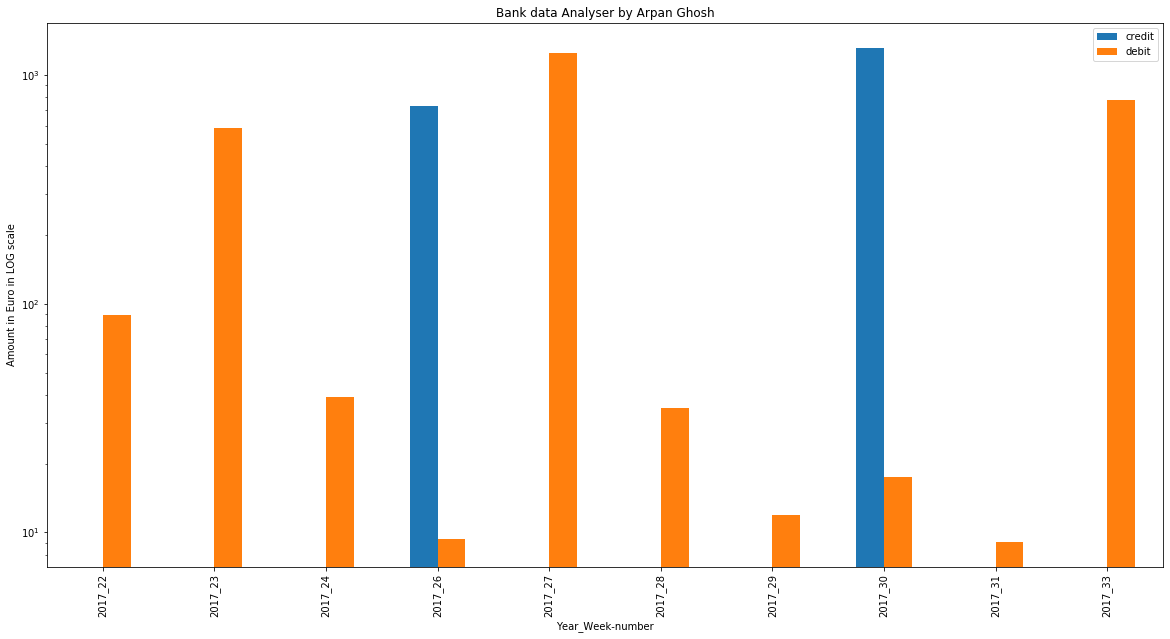

In [16]:
credit,debit,key_list = [],[],[]
Total_C = 0
Total_D = 0
count = 0
for key,df in data_gb:
    C = sum(df['Credit'].apply(lambda x: 0 if (x == ' ') else x).tolist())
    D = sum(df['Debit'].apply(lambda x: 0 if (x == ' ') else x).tolist())
    Total_C += C
    Total_D += D
    count += 1
    credit.append(C)
    debit.append(D)
    key_list.append(key)
summary = pandas.DataFrame({'key':key_list,'credit':credit,'debit':debit})
#summary.year_month = summary['key'].apply(pandas.Period.to_timestamp)
if choice == 'W':
    summary['key_year'] = summary['key']
    summary['key_week'] = summary['key']
    summary['key_year'] = summary['key_year'].apply(lambda x : int(x.split('_')[0]))
    summary.key_year = summary.key_year.astype(int)
    summary['key_week'] = summary['key_week'].apply(lambda x : int(x.split('_')[1]))
    summary.key_week = summary.key_week.astype(int)
    summary = summary.sort_values(['key_year','key_week'])
    summary = summary.drop(columns=['key_week', 'key_year'])
else:
    summary = summary.sort_values('key',ascending = False)

if choice == 'W':
    summary['key_'] = summary['key']
elif choice == 'M':
    summary['key_'] = summary['key'].apply(lambda x : x.strftime("%Y-%b"))
elif choice == 'Y':
    summary['key_'] = summary['key'].apply(lambda x : x.strftime("%Y"))
elif choice == 'D':
    summary['key_'] = summary['key'].apply(lambda x : x.strftime("%Y-%b-%d"))
if choice != 'W':
    ax = summary.plot(kind = 'bar',figsize=(20,10),x = 'key',grid = False,title = 'Bank data Analyser by Arpan Ghosh',logy = True)
else:
    ax = summary.plot(kind = 'bar',figsize=(20,10),grid = False,title = 'Bank data Analyser by Arpan Ghosh',logy = True)
ax.set_xticklabels(summary['key_'])
if choice == 'W':
    ax.set_xlabel("Year_Week-number")
    what = 'week'
elif choice == 'M':
    ax.set_xlabel("Year_Month-name")
    what = 'month'
elif choice == 'Y':
    ax.set_xlabel("Year")
    what = 'year'
elif choice == 'D':
    ax.set_xlabel("Date")
    what = 'day'

ax.set_ylabel("Amount in Euro in LOG scale")
#ax.set_ylim(0, 3000)
figure = ax.get_figure()
Max_C = data[data.Credit == data.Credit.max()]
Max_D = data[data.Debit == data.Debit.max()]
info = "Total Credit over the given Period : "+str(round(Total_C,3))+'\n'+"Total Debit over the given Period : "+str(round(Total_D,3))+'\n'+"Average Credit per "+what+" Over the given period : "+str(round((Total_C/count),3))+'\n'+"Average Debit per "+what+" Over the given period :"+str(round(Total_D/count,3))+'\n'+"Average Retention per "+what+" Over the given period : "+str(round((Total_C-Total_D)/count,3))+'\n'+"Standard Deviation of Credit : "+str(round(summary.credit.std(ddof=0),4))+'\n'+"Standard Deviation of Debit : "+str(round(summary.debit.std(ddof=0),4))+'\n'
info += "Maximum Credit of "+str(Max_C['Credit'].to_list()[0])+" was caused on "+str(Max_C['Value Date'].to_list()[0])+" because "+str(Max_C['Description'].to_list()[0])+'\n'+"Maximum Debit of "+str(Max_D['Debit'].to_list()[0])+" was caused on "+str(Max_D['Value Date'].to_list()[0])
info += " because "+str(Max_D['Description'].to_list()[0])+'\n'
print(info)
out_path = os.path.abspath(os.path.join(file_path, os.pardir))
if os.path.exists(out_path+'\\chart.pdf'):
    inp = input("File already exists ! want to replace ? (Y/N) : ")
    if inp == 'Y' or inp == 'y':
        out_path_pdf = out_path+'\\chart.pdf'
        out_path_txt = out_path+'\\chart.txt'
    else:
        name = input("Enter the file name only : ")
        out_path_pdf = out_path+"\\"+name+".pdf"
        out_path_txt = out_path+"\\"+name+".txt"
else:
    out_path_pdf = out_path+'\\chart.pdf'
    out_path_txt = out_path+'\\chart.txt'
out = open(out_path_txt,'w')
out.write(info)
out.close()
figure.savefig(os.path.abspath(os.path.join(file_path, os.pardir))+'\\chart.pdf')

In [17]:
data

,Txn Date,Value Date,Description,Credit,Debit,year_month_date,year_month,year,week
24,2017-06-02,2017-06-01,DIPAN GHOSH REWE Muenchen/Schw Muenchen Karten...,0.00,17.55,2017-06-01,2017-06,2017,2017_22
22,2017-06-02,2017-06-01,DIPAN GHOSH 1.50% AUSLANDSEINSATZENTG Karten-N...,0.00,1.06,2017-06-01,2017-06,2017,2017_22
23,2017-06-02,2017-06-01,DIPAN GHOSH AMAZONS AODS BANGALORE INR 5...,0.00,70.61,2017-06-01,2017-06,2017,2017_22
21,2017-06-07,2017-06-06,DIPAN GHOSH MVG AUTOMATEN MUENCHEN Karten-Nr. ...,0.00,80.00,2017-06-06,2017-06,2017,2017_23
20,2017-06-07,2017-06-06,DIPAN GHOSH MVG AUTOMATEN MUENCHEN Karten-Nr. ...,0.00,80.00,2017-06-06,2017-06,2017,2017_23
19,2017-06-07,2017-06-06,DIPAN GHOSH BARGELDAUSZAHLUNGSGEBUEHR Karten-N...,0.00,2.00,2017-06-06,2017-06,2017,2017_23
18,2017-06-07,2017-06-06,DIPAN GHOSH RAIFFEISENBANK M.NCH A MUENCHEN Ka...,0.00,70.00,2017-06-06,2017-06,2017,2017_23
17,2017-06-08,2017-06-07,DIPAN GHOSH GOOGLE *SVCSdd97d0e4-4 g.co/payhel...,0.00,10.00,2017-06-07,2017-06,2017,2017_23
16,2017-06-12,2017-06-09,DIPAN GHOSH Interplan AG Kongress 089-54823416...,0.00,345.00,2017-06-09,2017-06,2017,2017_23
15,2017-06-13,2017-06-12,DIPAN GHOSH TAJ KRISHNA MUENCHEN Karten-Nr. 52...,0.00,12.90,2017-06-12,2017-06,2017,2017_24
